# Example Usage for Packaged Neural Networks

In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

os.chdir('/home/120/em8117/BayesHI') # Replace this with the location of the BayesHI directory
import bayeshi

In [7]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

## Load one of the models

In [9]:
model = bayeshi.load_model('bayeshi')

In [10]:
model = model.to(device)

## Load the pre-trained weights for the model

In [11]:
model.load_weights()

Loading model from /scratch/fd08/em8117/training_process/TIGRESS_grid_search/TIGRESS_pesinusoidal_c1_k8_wone31_wtwo3_km2_ptoff_mha4_t1_e100_lr0.0001_s15_p20_tol1e-4_kl0.01/run1/TIGRESS_model_best_model_full.pth
Model loaded successfully


## Predict on some dummy spectra

In [12]:
spectra = bayeshi.generate_spectra()

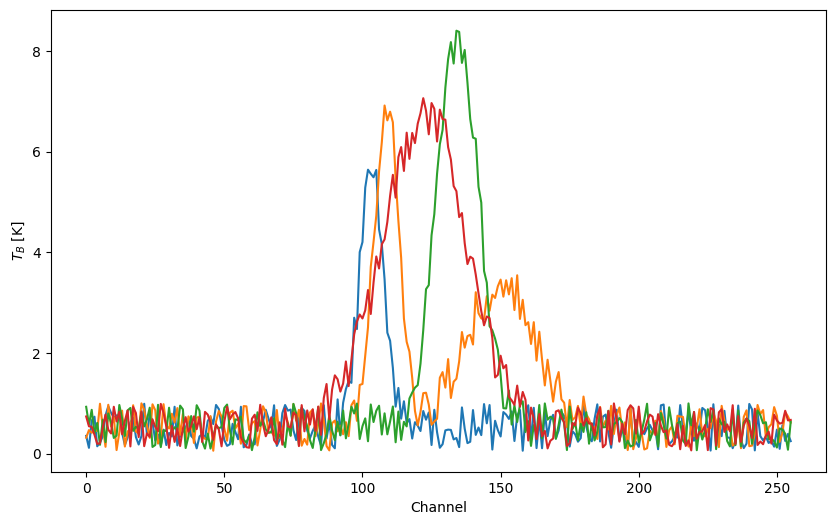

In [13]:
plt.figure(figsize=(10,6))
plt.plot(spectra[45:49].T)
plt.xlabel('Channel')
plt.ylabel(r'$T_B$ [K]')
plt.show()

### Create a dataloader from the dummy spectra

In [14]:
data_loader = DataLoader(
    TensorDataset(
        torch.Tensor(spectra).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

### Predict on the spectra

In [15]:
predictions = model.predict(data_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 41.84it/s]


### Take the average and standard deviation of the errors

In [16]:
avg_prediction = np.mean(predictions, axis = 0)
std_prediction = np.std(predictions, axis = 0)

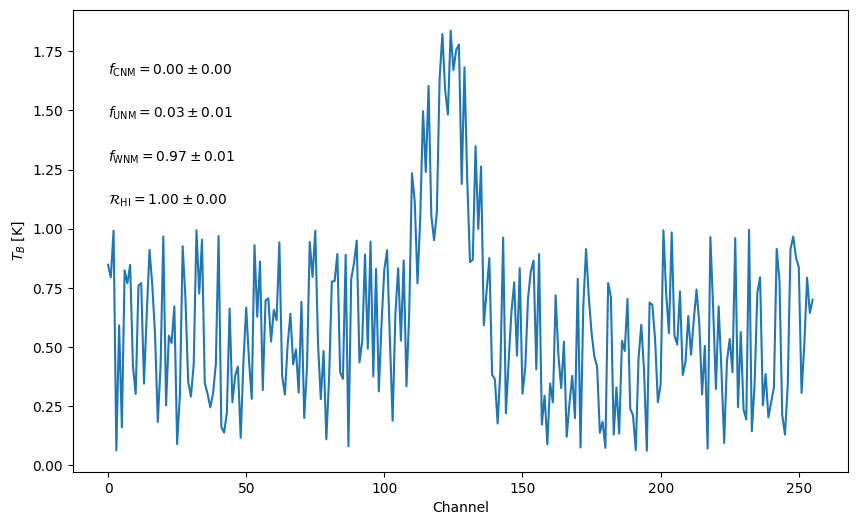

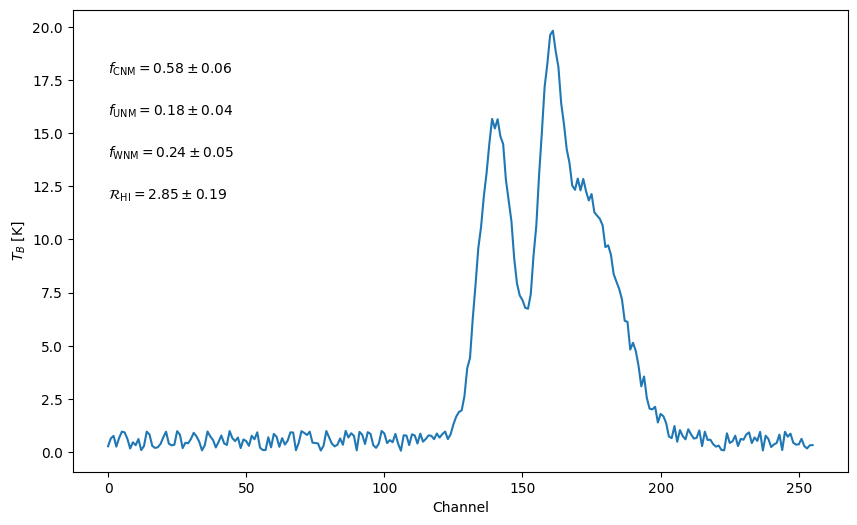

In [18]:
# Get the spectra with the highest and lowest predicted fcnm
min_cnm = np.argmin(avg_prediction[:,0])
max_cnm = np.argmax(avg_prediction[:,0])

bayeshi.plot_spectrum(spectra, predictions, min_cnm)
bayeshi.plot_spectrum(spectra, predictions, max_cnm)

## Train the network

In [19]:
# This reinitialises the model
model = bayeshi.load_model('bayeshi')

In [20]:
model = model.to(device)

### Generate dummy spectra and targets ($f_\text{CNM}$, $f_\text{UNM}$, $f_\text{WNM}$, $\mathcal{R}_\text{HI}$)

In [21]:
spectra = bayeshi.generate_spectra(num_spectra=10000, max_components=6)
# Fractions must sum to one
fractions = np.random.dirichlet(alpha=[1, 1, 1], size=10000)
rhi = 1 + np.random.exponential(scale=0.05, size=(10000,1))

targets = np.concatenate((fractions,rhi),axis=1)

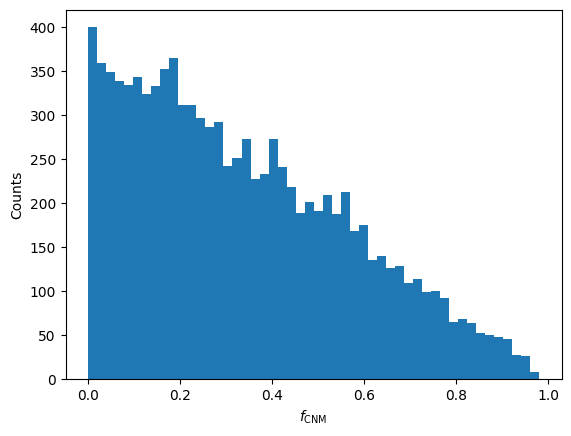

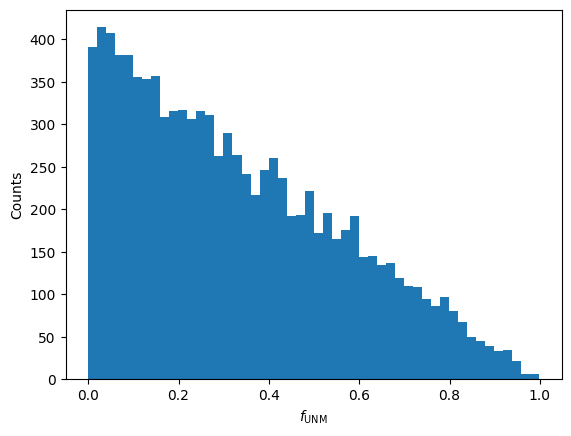

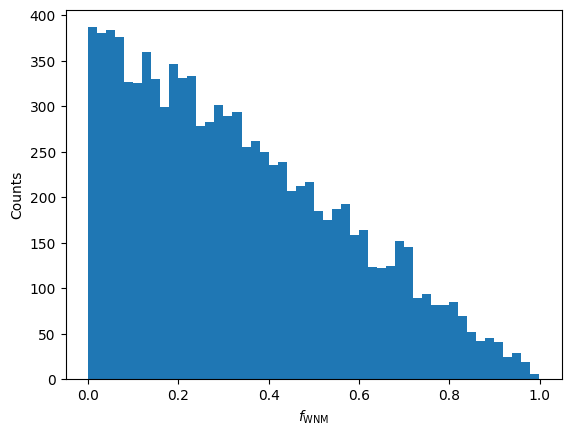

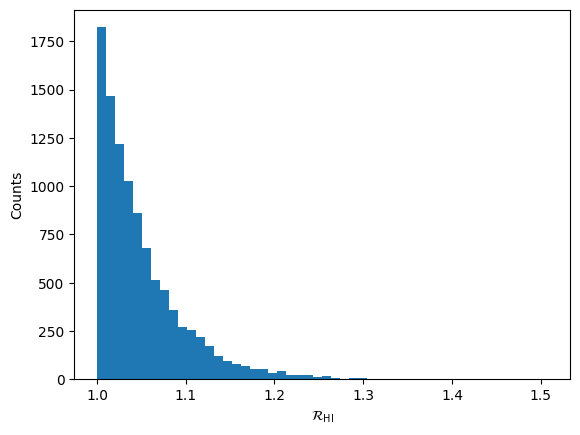

In [22]:
plt.hist(targets[:,0],bins=50)
plt.xlabel(r'$f_\text{CNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,1],bins=50)
plt.xlabel(r'$f_\text{UNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,2],bins=50)
plt.xlabel(r'$f_\text{WNM}$')
plt.ylabel('Counts')
plt.show()

plt.hist(targets[:,3],bins=50)
plt.xlabel(r'$\mathcal{R}_\text{HI}$')
plt.ylabel('Counts')
plt.show()

### Create a dataloader from the dummy spectra and targets

In [23]:
# Split into train and validation sets with 80:20 split
X_train, X_val, y_train, y_val = train_test_split(spectra, targets, test_size=0.2, random_state=42)

train_loader = DataLoader(
    TensorDataset(
        torch.Tensor(X_train).to(device),
        torch.Tensor(y_train).to(device)
    ), 
    batch_size=32, 
    shuffle=True
)

val_loader = DataLoader(
    TensorDataset(
        torch.tensor(X_val).to(device),
        torch.tensor(y_val).to(device)
    ),
    batch_size=32,
    shuffle=False
)

### Train the network

In [24]:
train_errors, val_errors, trained_epochs, epoch_times = model.fit(train_loader, val_loader, './checkpoints/dummy_bayeshi.pth', nEpochs=50)

Training Model
Initial learning rate: [0.0001]
Epoch [1/50], Train Loss: 0.5355, Validation Loss: 0.2304, took 4.46s
Epoch [2/50], Train Loss: 0.1692, Validation Loss: 0.1679, took 4.33s
Epoch [3/50], Train Loss: 0.1807, Validation Loss: 0.1830, took 4.32s
Epoch [4/50], Train Loss: 0.1713, Validation Loss: 0.1689, took 4.32s
Epoch [5/50], Train Loss: 0.1699, Validation Loss: 0.1560, took 4.31s
Epoch [6/50], Train Loss: 0.1661, Validation Loss: 0.1572, took 4.32s
Epoch [7/50], Train Loss: 0.1705, Validation Loss: 0.1597, took 4.31s
Epoch [8/50], Train Loss: 0.1660, Validation Loss: 0.1611, took 4.31s
Epoch [9/50], Train Loss: 0.1647, Validation Loss: 0.1691, took 4.31s
Epoch [10/50], Train Loss: 0.1630, Validation Loss: 0.1664, took 4.31s
Epoch [11/50], Train Loss: 0.1602, Validation Loss: 0.1706, took 4.31s
Epoch [12/50], Train Loss: 0.1620, Validation Loss: 0.1609, took 4.31s
Epoch [13/50], Train Loss: 0.1677, Validation Loss: 0.1557, took 4.31s
Epoch [14/50], Train Loss: 0.1638, Vali

### Load the trained network parameters

In [25]:
model.load_weights('./checkpoints/dummy_bayeshi.pth')

Loading model from ./checkpoints/dummy_bayeshi.pth
Model loaded successfully


### Plot training and testing losses

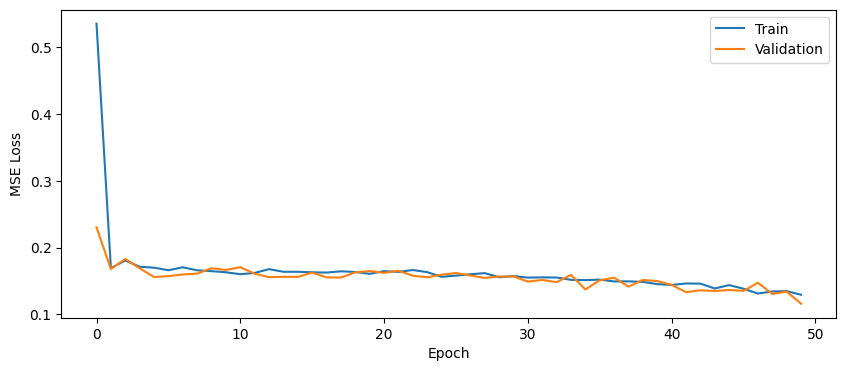

In [26]:
plt.figure(figsize=(10,4))
plt.plot(train_errors, label='Train')
plt.plot(val_errors, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

### Get test loss and predict on a test set

In [27]:
test_spectra = bayeshi.generate_spectra(num_spectra=1000, max_components=6)

test_fractions = np.random.dirichlet(alpha=[1, 1, 1], size=1000)
test_rhi = 1 + np.random.exponential(scale=0.05, size=(1000,1))
test_targets = np.concatenate((test_fractions, test_rhi),axis=1)

test_loader = DataLoader(
    TensorDataset(
        torch.Tensor(test_spectra).to(device),
        torch.Tensor(test_targets).to(device)
    ), 
    batch_size=32, 
    shuffle=False
)

In [28]:
from torch import nn
test_loss = model.evaluate(test_loader, nn.MSELoss())
print('Test loss (MSE):', test_loss)

Test loss (MSE): 0.12317537516355515


In [29]:
test_predictions = model.predict(test_loader, numPredictions=10).cpu().numpy()

Predicting: 100%|██████████| 10/10 [00:00<00:00, 27.68it/s]


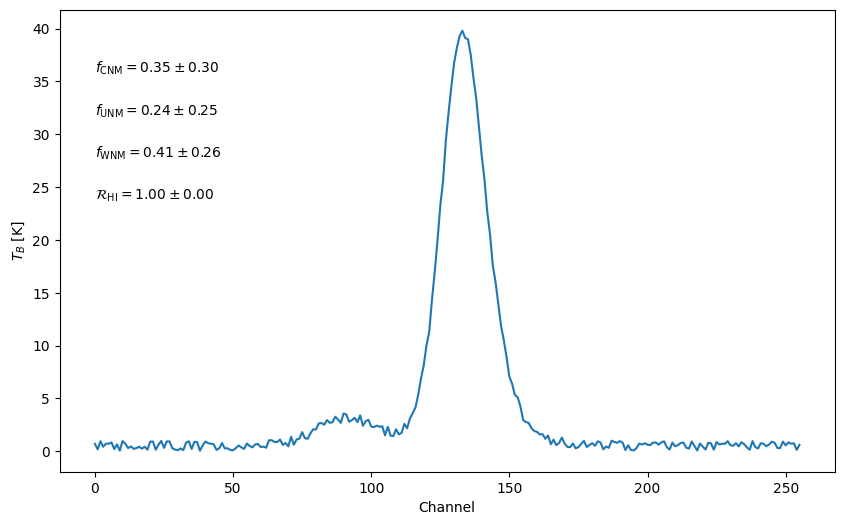

In [30]:
bayeshi.plot_spectrum(test_spectra, test_predictions, 8)

### Plot some one-to-one plots

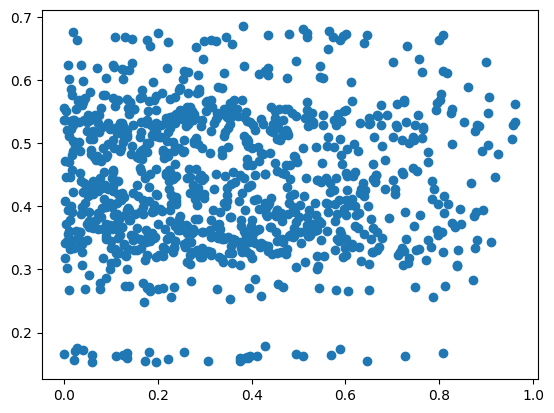

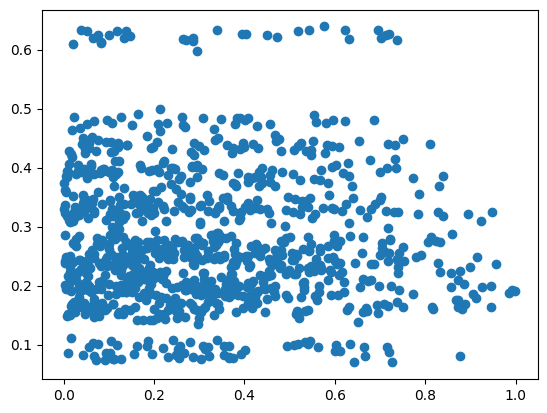

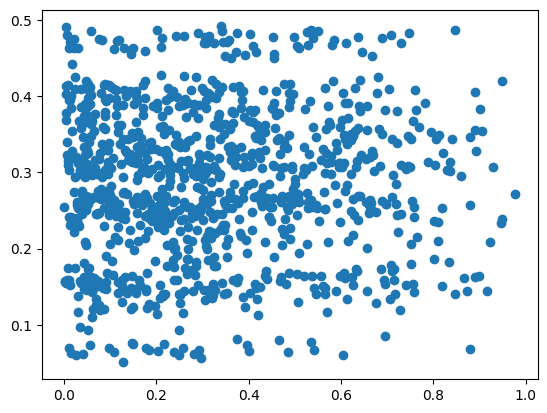

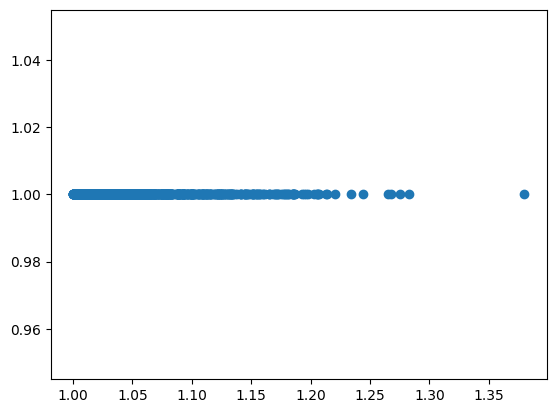

In [31]:
for i in range(4):
    plt.scatter(test_targets[:,i], np.mean(test_predictions,axis=0)[:,i])
    plt.show()